# Предварительная подготовка данных

In [298]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [299]:
# Считываем данные
df = pd.read_csv('./data/digit.dat', sep = ';')
df.columns

Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'A2', 'B2', 'C2', 'D2', 'E2',
       'F2', 'G2', 'H2'],
      dtype='object')

По неизвестной причине в таблице данных каждый столбец присутствует дважды.

Разобъем исходный датасет на два и сравним их на сходство.

In [300]:
mid = len(df.columns) // 2
df_01 = df.iloc[:, :mid]
df_01.head()

,A,B,C,D,E,F,G,H
0,seven,ONE,ZERO,ONE,ZERO,ZERO,ONE,ZERO
1,one,ZERO,ZERO,ONE,ZERO,ZERO,ONE,ZERO
2,four,ZERO,ONE,ONE,ONE,ZERO,ONE,ZERO
3,two,ONE,ONE,ONE,ONE,ONE,ZERO,ZERO
4,eight,ZERO,ONE,ONE,ONE,ONE,ONE,ONE


In [301]:
# Уберем лишние пробелы в значениях

df_01 = df_01.map(lambda x: x.strip())

In [302]:
df_02 = df.iloc[:, mid:]
df_02.head()

,A2,B2,C2,D2,E2,F2,G2,H2
0,seven,ONE,ZERO,ONE,ZERO,ZERO,ONE,ZERO
1,one,ZERO,ZERO,ONE,ZERO,ZERO,ONE,ZERO
2,four,ZERO,ONE,ONE,ONE,ZERO,ONE,ZERO
3,two,ONE,ONE,ONE,ONE,ONE,ZERO,ZERO
4,eight,ZERO,ONE,ONE,ONE,ONE,ONE,ONE


In [303]:
# Подсчитаем число различий в двух фреймах

diffs = 0
for row_01, row_02 in zip(df_01.itertuples(), df_02.itertuples()):
    diffs += row_01 != row_02
diffs

0

Их нет, поэтому будем работать с одним из них (df_01).

Произведем замену: ZERO - 0, ONE - 1; а также для цифр.

In [304]:
mapping = {
    'ZERO': 0, 'ONE': 1,
    'zero': 0, 'one': 1, 'two': 2, 'three': 3,
    'four': 4, 'five': 5, 'six': 6, 'seven': 7,
    'eight': 8, 'nine': 9, 'ten': 10
}

df_01 = df_01.replace(mapping)
df_01 = df_01.infer_objects(copy = False)

df_01.head()

C:\Users\mshsv\AppData\Local\Temp\ipykernel_12876\3948573123.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_01 = df_01.replace(mapping)


,A,B,C,D,E,F,G,H
0,7,1,0,1,0,0,1,0
1,1,0,0,1,0,0,1,0
2,4,0,1,1,1,0,1,0
3,2,1,1,1,1,1,0,0
4,8,0,1,1,1,1,1,1


In [305]:
df = df_01
df_clear = df.drop(columns = 'A')

In [306]:
# Функция для визулизации цифр

def digit_visual(df_mean, ncols = 3):
   
    height = 9
    width = 5
    
    horizontal = ["h" + str(i) for i in range(width)] * height
    vertical = ["v" + str(i) for i in range(height) for _ in range(width)]
    
    n_digits = len(df_mean)
    nrows = (n_digits + ncols - 1) // ncols
    
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize = (ncols * 2.5, nrows * 3),
        sharex = True, sharey = True
    )
    
    if nrows == 1:
        axes = axes.reshape(1, -1)
    if ncols == 1:
        axes = axes.reshape(-1, 1)

    for idx in range(n_digits):
        b = df_mean.iloc[idx]["B"]
        c = df_mean.iloc[idx]["C"]
        d = df_mean.iloc[idx]["D"]
        e = df_mean.iloc[idx]["E"]
        f = df_mean.iloc[idx]["F"]
        g = df_mean.iloc[idx]["G"]
        h = df_mean.iloc[idx]["H"]
        
        value = (
            [0, b, b, b, 0] +
            [c, 0, 0, 0, d] * 3 +
            [0, e, e, e, 0] +
            [f, 0, 0, 0, g] * 3 +
            [0, h, h, h, 0]
        )
        
        digit = pd.DataFrame({
            "h": horizontal,
            "v": vertical,
            "value": value,
        })
        digit_to_plot = digit.pivot(index = "v", columns = "h", values = "value")
        
        row = idx // ncols
        col = idx % ncols
        
        sns.heatmap(
            digit_to_plot,
            ax = axes[row, col],
            cmap = "Blues",
            xticklabels = False,
            yticklabels = False
        )

        if fcluster:
            axes[row, col].set_title(f"{df_mean.index[idx]}", fontsize = 12, pad = 10)


    for idx in range(n_digits, nrows * ncols):
        row = idx // ncols
        col = idx % ncols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

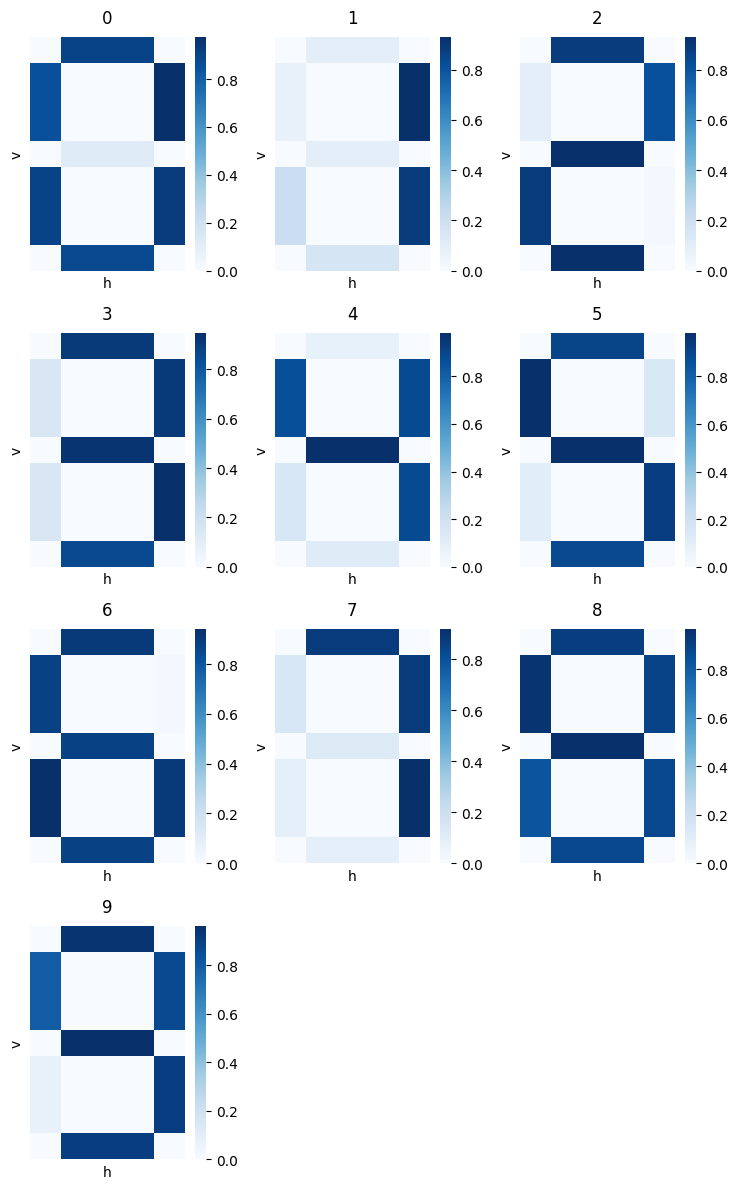

In [307]:
# Визуализируем исходные данные

digit_visual(df.groupby('A').mean())

# Иерархический кластерный анализ

In [308]:
#  Кластеризуем
# link - матрица связей
link = linkage(df_clear, 'ward', 'euclidean')
link.shape

(499, 4)

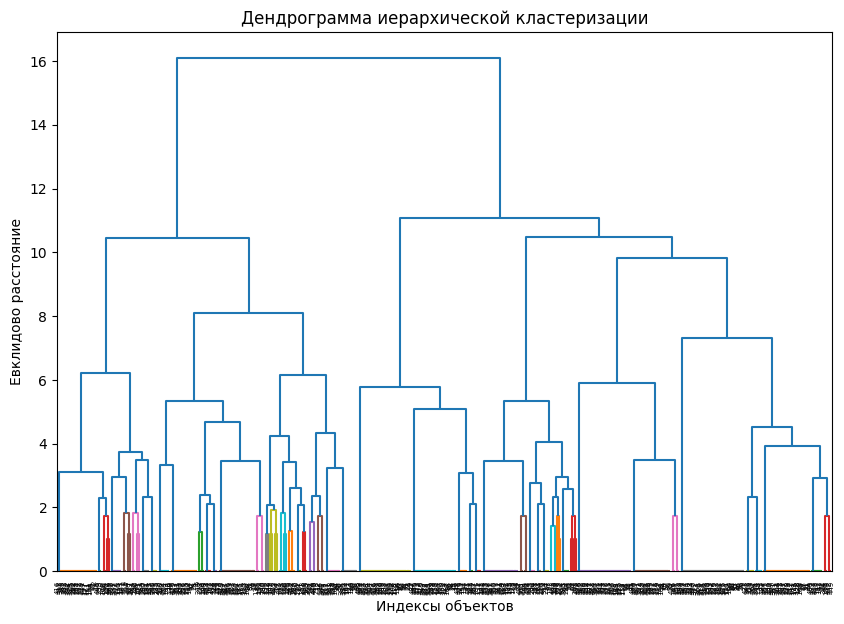

In [309]:
plt.figure(figsize = (10, 7))
dendrogram(link, color_threshold = 2)
plt.title('Дендрограмма иерархической кластеризации')
plt.xlabel('Индексы объектов')
plt.ylabel('Евклидово расстояние')
plt.show()

In [310]:
# Перебор значений t

t = None
t_vals = np.arange(0.0, 11.0, 0.05)
res = []

for val in t_vals:
    labels = fcluster(link, val, criterion = 'distance')
    # print(len(np.unique(labels)))
    if len(np.unique(labels)) == 10:
        res.append(val)

t = sum(res) / len(res)
t

np.float64(6.05)

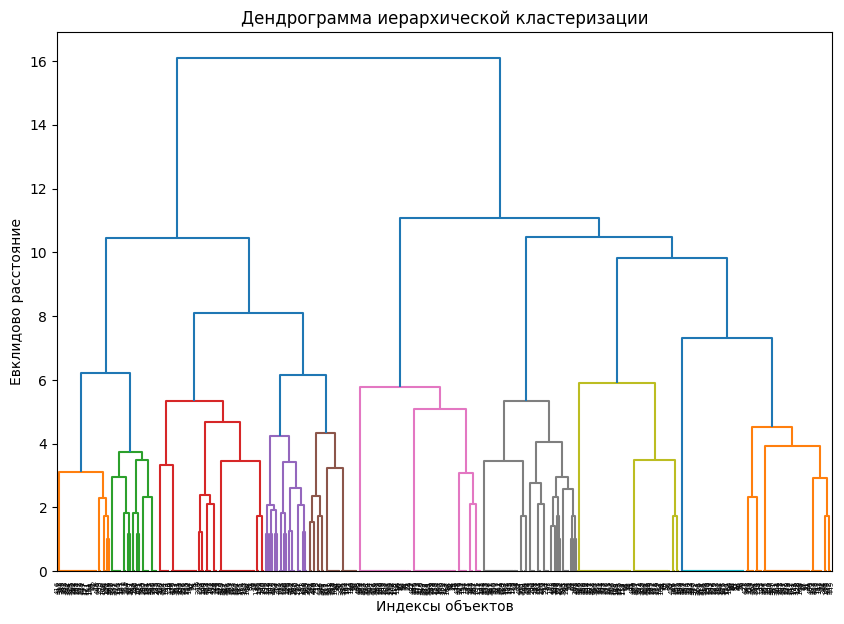

In [311]:
plt.figure(figsize = (10, 7))
dendrogram(link, color_threshold = t)
plt.title('Дендрограмма иерархической кластеризации')
plt.xlabel('Индексы объектов')
plt.ylabel('Евклидово расстояние')
plt.show()

In [312]:
df['fcluster'] = fcluster(link, t, criterion = 'distance')
df.head()

,A,B,C,D,E,F,G,H,fcluster
0,7,1,0,1,0,0,1,0,3
1,1,0,0,1,0,0,1,0,3
2,4,0,1,1,1,0,1,0,1
3,2,1,1,1,1,1,0,0,7
4,8,0,1,1,1,1,1,1,2


In [313]:
# Число кластеров

len(df['fcluster'].unique())

10

In [314]:
df.groupby('fcluster')['A'].count()

fcluster
1     34
2     31
3     69
4     28
5     32
6     80
7     61
8     67
9     42
10    56
Name: A, dtype: int64

In [315]:
df.groupby('A')['B'].count()

A
0    42
1    43
2    43
3    55
4    52
5    54
6    50
7    48
8    58
9    55
Name: B, dtype: int64

In [316]:
df.groupby('A').mean()

,B,C,D,E,F,G,H,fcluster
A,,,,,,,,
0,0.904762,0.857143,0.976190,0.119048,0.904762,0.928571,0.880952,7.095238
1,0.093023,0.069767,0.930233,0.093023,0.209302,0.883721,0.162791,4.069767
2,0.883721,0.093023,0.813953,0.930233,0.883721,0.023256,0.930233,6.953488
3,0.909091,0.145455,0.909091,0.927273,0.145455,0.945455,0.854545,8.563636
4,0.076923,0.865385,0.884615,0.980769,0.153846,0.884615,0.115385,2.230769
5,0.907407,0.981481,0.148148,0.981481,0.111111,0.925926,0.888889,5.814815
6,0.900000,0.880000,0.020000,0.880000,0.940000,0.900000,0.880000,5.440000
7,0.875000,0.145833,0.875000,0.125000,0.083333,0.916667,0.083333,3.583333
8,0.913793,0.948276,0.896552,0.965517,0.827586,0.879310,0.879310,7.120690


In [317]:
df.groupby('fcluster').mean()

,A,B,C,D,E,F,G,H
fcluster,,,,,,,,
1,3.705882,0.029412,0.852941,1.000000,1.000000,0.000000,0.852941,0.000000
2,5.129032,0.000000,0.967742,0.548387,0.903226,0.548387,0.967742,0.806452
3,4.159420,0.507246,0.188406,1.000000,0.000000,0.115942,0.913043,0.057971
4,5.214286,0.785714,0.678571,0.000000,0.428571,0.428571,0.964286,0.214286
5,5.125000,1.000000,0.531250,1.000000,0.812500,0.343750,1.000000,0.000000
6,5.537500,1.000000,0.800000,0.000000,1.000000,0.475000,0.950000,1.000000
7,3.704918,0.836066,0.344262,0.754098,0.983607,0.754098,0.000000,0.885246
8,4.477612,1.000000,0.955224,1.000000,0.537313,1.000000,0.910448,1.000000
9,7.500000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000


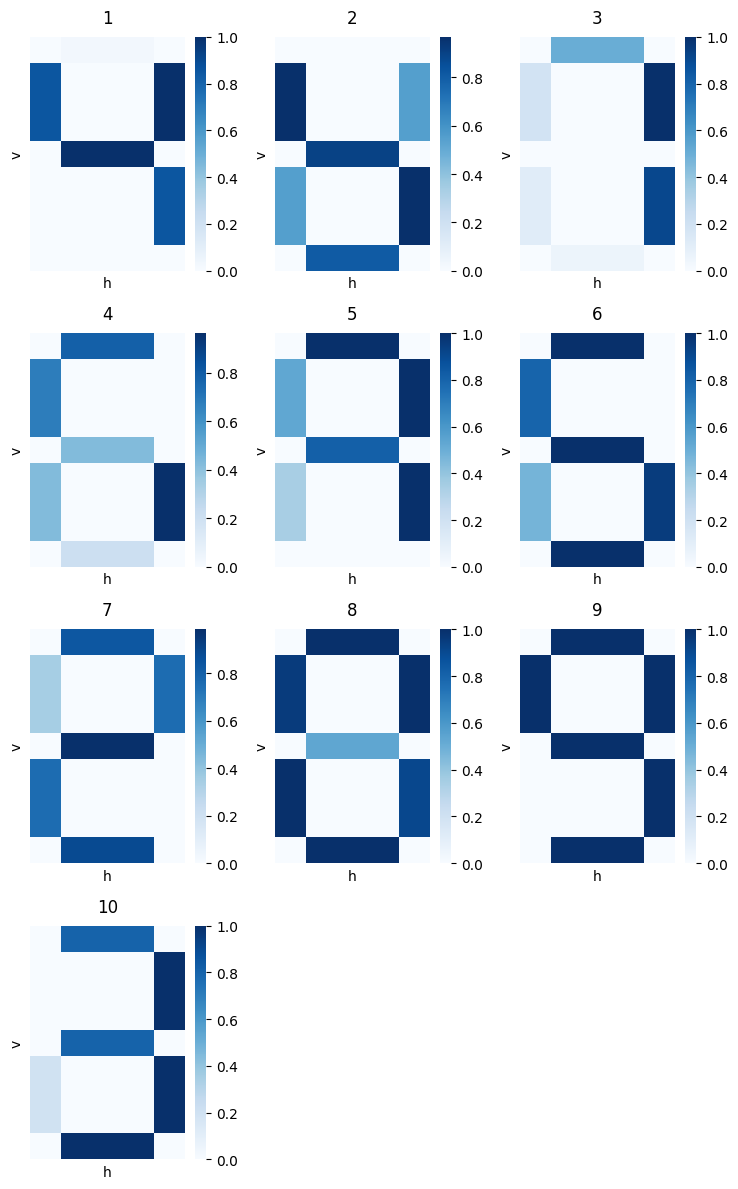

In [318]:
# Визуализируем данные, полученные в результате иерархической кластеризации

digit_visual(df.groupby('fcluster').mean())

In [319]:
# Самые часто встречаемые цифры после кластеризации
df.groupby('fcluster')['A'].apply(lambda x: x.mode()[0])

fcluster
1     4
2     4
3     7
4     6
5     3
6     5
7     2
8     8
9     9
10    3
Name: A, dtype: int64

In [320]:
# Детальнее рассмотрим 2й кластер
df[df['fcluster'] == 2].groupby('A').count()

,B,C,D,E,F,G,H,fcluster
A,,,,,,,,
0,3,3,3,3,3,3,3,3
3,1,1,1,1,1,1,1,1
4,10,10,10,10,10,10,10,10
5,5,5,5,5,5,5,5,5
6,4,4,4,4,4,4,4,4
8,5,5,5,5,5,5,5,5
9,3,3,3,3,3,3,3,3


In [321]:
df[(df['fcluster'] == 2) & (df['A'] == 4)]

,A,B,C,D,E,F,G,H,fcluster
101,4,0,1,1,1,1,1,0,2
123,4,0,1,1,1,0,1,1,2
127,4,0,1,1,1,0,1,1,2
136,4,0,1,1,1,0,1,1,2
152,4,0,1,0,1,1,1,0,2
307,4,0,1,1,1,0,1,1,2
340,4,0,1,0,1,1,1,0,2
411,4,0,1,1,1,1,1,0,2
463,4,0,1,1,1,0,1,1,2
464,4,0,1,0,1,1,1,0,2


In [322]:
# Детальнее рассмотрим 5й кластер
df[df['fcluster'] == 5].groupby('A').count()

,B,C,D,E,F,G,H,fcluster
A,,,,,,,,
0,3,3,3,3,3,3,3,3
1,2,2,2,2,2,2,2,2
3,7,7,7,7,7,7,7,7
4,4,4,4,4,4,4,4,4
5,1,1,1,1,1,1,1,1
7,5,5,5,5,5,5,5,5
8,5,5,5,5,5,5,5,5
9,5,5,5,5,5,5,5,5


### Выводы:
- Кластер 1: 4 (C, D, E, G = 1)
- Кластер 3: 7 (B, D, G = 1)
- Кластер 4: 6 (B, E, H)
- Кластер 6: 5
- Кластер 7: 7
- Кластер 8: 8
- Кластер 9: 9
- Кластер 10: 3

Еще:
- в кластере 2 преобладает цифра 4
- в кластере 5 находится "микс" из цифр

# Кластерный анализ методом к-средних (k-means)

In [323]:
dist = []
clusters = [i for i in range(1, 30)]

for clust in clusters:

    clf = KMeans(n_clusters = clust, max_iter = 300, n_init = 10, random_state = 23)
    clf.fit(df_clear)
    dist.append(clf.inertia_)

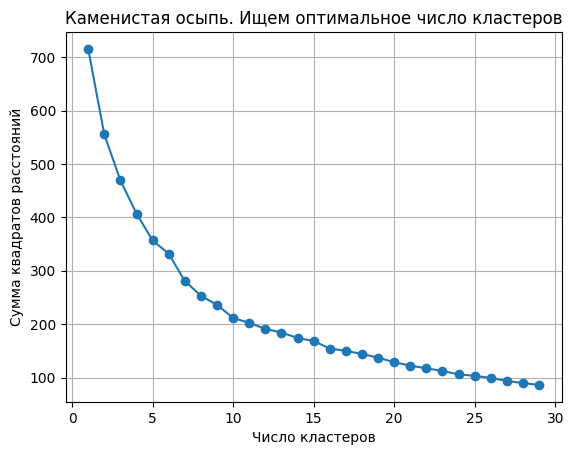

In [324]:
# Строим график "каменистая осыпь"

plt.plot(clusters, dist, marker='o')
plt.grid(True)
plt.xlabel('Число кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Каменистая осыпь. Ищем оптимальное число кластеров')
plt.show()

In [ ]:
# Проведем кластеризацию для 10 кластеров
clf = KMeans(n_clusters = 10, n_init = 10, random_state = 23)
clf.fit(df_clear)

KMeans(n_clusters=11, n_init=10, random_state=23)

In [528]:
# Определим число объектов в каждом кластере
counts, unique = np.unique(clf.labels_, return_counts = True)
pd.Series(unique, counts)

0     47
1     59
2     53
3     13
4     41
5     61
6     57
7     44
8     49
9     42
10    34
dtype: int64

In [529]:
df['KMeans'] = clf.labels_
df

,A,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
0,7,1,0,1,0,0,1,0,3,2,0
1,1,0,0,1,0,0,1,0,3,8,1
2,4,0,1,1,1,0,1,0,1,7,2
3,2,1,1,1,1,1,0,0,7,0,-1
4,8,0,1,1,1,1,1,1,2,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
495,5,1,1,0,1,0,1,1,6,6,3
496,7,1,0,1,1,1,1,0,5,3,-1
497,4,0,0,1,1,1,0,0,7,4,-1
498,0,1,1,1,0,0,1,0,3,2,-1


In [530]:
df.groupby('KMeans').mean()

,A,B,C,D,E,F,G,H,fcluster,DBSCAN
KMeans,,,,,,,,,,
0,7.255319,0.936170,1.000000,1.000000,1.000000,1.000000,0.893617,0.914894,7.319149,4.361702
1,7.135593,0.847458,1.000000,1.000000,0.932203,0.000000,0.915254,1.000000,7.474576,3.271186
2,5.603774,1.000000,0.113208,0.924528,0.226415,0.056604,0.924528,0.056604,3.924528,-0.547170
3,2.769231,1.000000,0.000000,1.000000,0.769231,1.000000,1.000000,0.846154,9.230769,-1.000000
4,2.365854,0.829268,0.000000,0.804878,0.926829,0.951220,0.000000,0.902439,6.975610,1.926829
5,5.885246,0.852459,0.918033,0.000000,0.885246,1.000000,0.852459,0.803279,5.245902,2.803279
6,5.421053,0.894737,0.859649,0.000000,0.947368,0.000000,0.964912,0.929825,5.368421,1.456140
7,4.590909,0.250000,1.000000,0.977273,1.000000,0.068182,0.909091,0.000000,2.250000,0.772727
8,2.183673,0.000000,0.081633,0.877551,0.142857,0.204082,0.897959,0.122449,3.714286,-0.265306


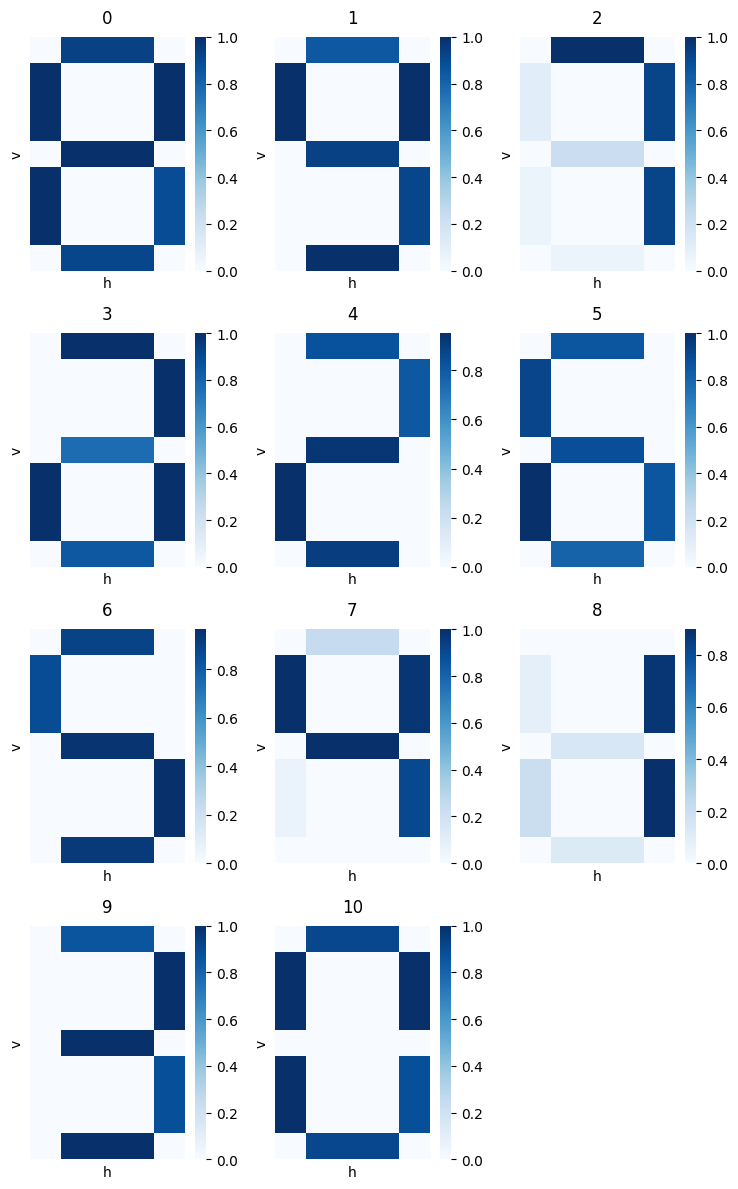

In [531]:
# Визуализируем данные, полученные в результате кластеризации k-means

digit_visual(df.groupby('KMeans').mean())

In [532]:
# Детальнее рассмотрим 0й кластер
df[df['KMeans'] == 0].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
0,2,2,2,2,2,2,2,2,2,2
2,2,2,2,2,2,2,2,2,2,2
5,2,2,2,2,2,2,2,2,2,2
6,1,1,1,1,1,1,1,1,1,1
8,39,39,39,39,39,39,39,39,39,39
9,1,1,1,1,1,1,1,1,1,1


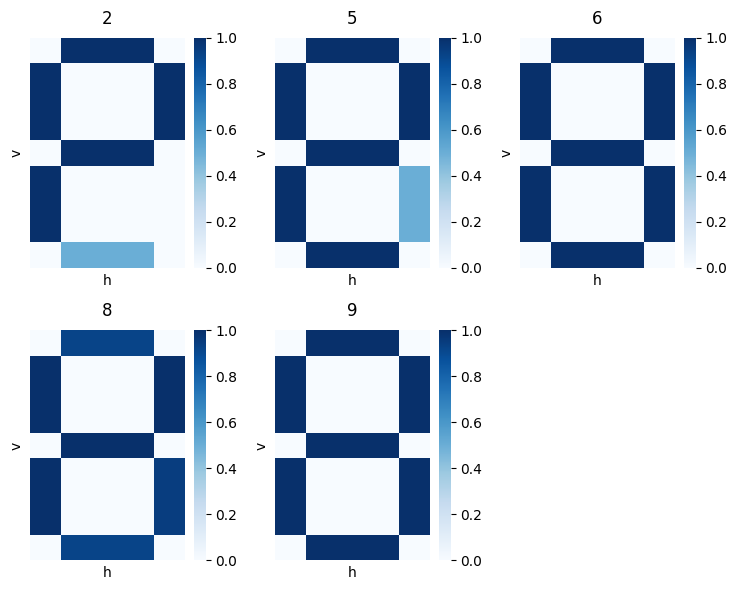

In [533]:
res = df[(df['KMeans'] == 0) & ((df['A'] == 1) | (df['A'] == 2) | (df['A'] == 3) |
                                (df['A'] == 4) | (df['A'] == 5) | (df['A'] == 6) |
                                (df['A'] == 7) | (df['A'] == 8) | (df['A'] == 9))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                                                     'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [534]:
# Детальнее рассмотрим 1й кластер
df[df['KMeans'] == 1].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
0,3,3,3,3,3,3,3,3,3,3
3,5,5,5,5,5,5,5,5,5,5
4,5,5,5,5,5,5,5,5,5,5
5,5,5,5,5,5,5,5,5,5,5
7,1,1,1,1,1,1,1,1,1,1
8,6,6,6,6,6,6,6,6,6,6
9,34,34,34,34,34,34,34,34,34,34


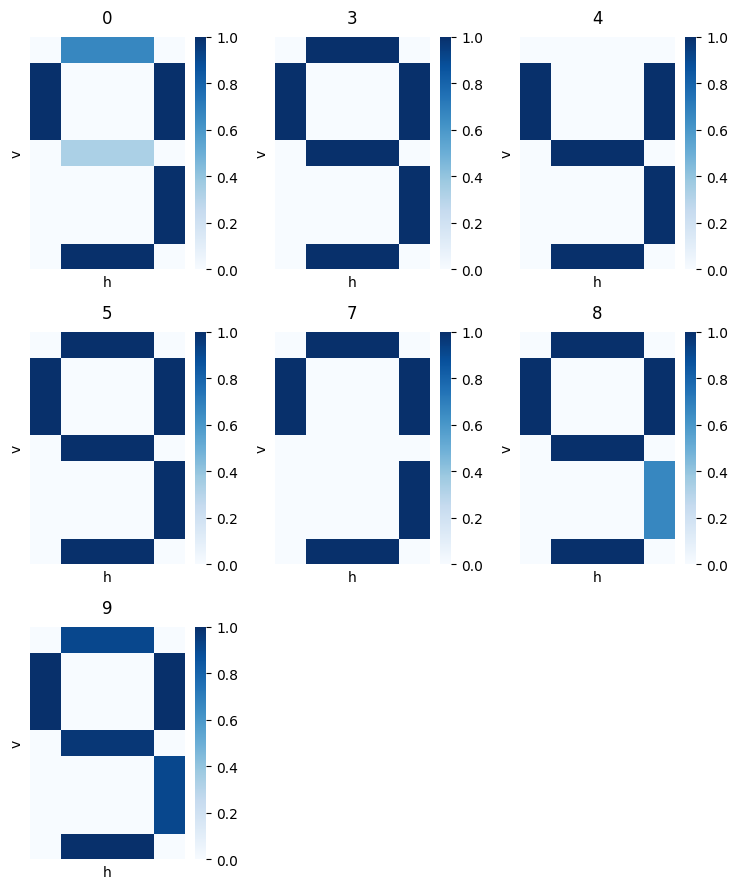

In [535]:
res = df[(df['KMeans'] == 1) & ((df['A'] == 0) | (df['A'] == 3) | (df['A'] == 4) |
                                (df['A'] == 5) | (df['A'] == 7) | (df['A'] == 8) |
                                (df['A'] == 9))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                   'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [536]:
# Детальнее рассмотрим 2й кластер
df[df['KMeans'] == 2].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
0,2,2,2,2,2,2,2,2,2,2
1,4,4,4,4,4,4,4,4,4,4
3,9,9,9,9,9,9,9,9,9,9
7,38,38,38,38,38,38,38,38,38,38


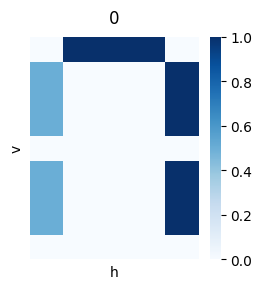

In [537]:
res = df[(df['KMeans'] == 2) & ((df['A'] == 0) | (df['A'] == 2) | (df['A'] == 4) |
                                (df['A'] == 5) | (df['A'] == 6) | (df['A'] == 8) |
                                (df['A'] == 9))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                   'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [538]:
# Детальнее рассмотрим 3й кластер
df[df['KMeans'] == 3].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
0,4,4,4,4,4,4,4,4,4,4
3,7,7,7,7,7,7,7,7,7,7
7,1,1,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1,1,1


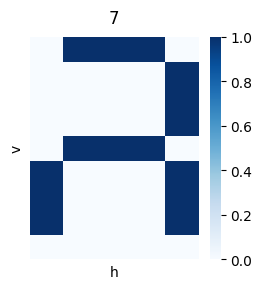

In [539]:
res = df[(df['KMeans'] == 3) & (df['A'] == 7)].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                 'F': 'mean', 'G': 'mean', 'H': 'mean'})
digit_visual(res)

In [540]:
# Детальнее рассмотрим 4й кластер
df[df['KMeans'] == 4].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1
2,35,35,35,35,35,35,35,35,35,35
3,1,1,1,1,1,1,1,1,1,1
4,2,2,2,2,2,2,2,2,2,2
7,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1,1,1


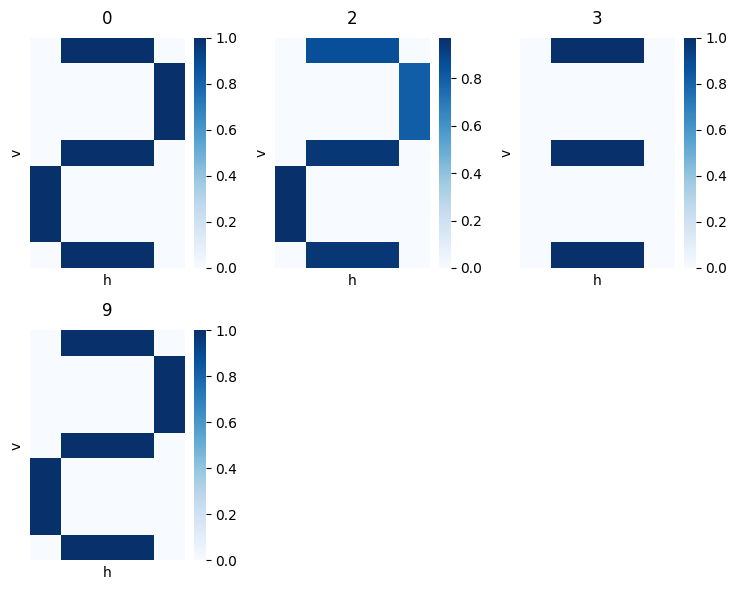

In [541]:
res = df[(df['KMeans'] == 4) & ((df['A'] == 0) | (df['A'] == 2) | (df['A'] == 3) |
                                (df['A'] == 8) | (df['A'] == 9))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                                    'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [542]:
# Детальнее рассмотрим 5й кластер
df[df['KMeans'] == 5].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1
4,3,3,3,3,3,3,3,3,3,3
5,4,4,4,4,4,4,4,4,4,4
6,46,46,46,46,46,46,46,46,46,46
8,5,5,5,5,5,5,5,5,5,5
9,1,1,1,1,1,1,1,1,1,1


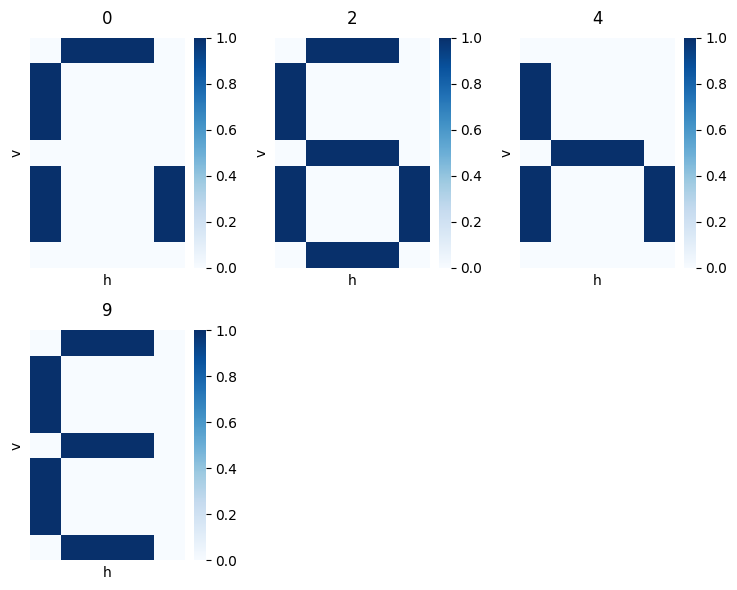

In [543]:
res = df[(df['KMeans'] == 5) & ((df['A'] == 0) | (df['A'] == 2) | (df['A'] == 4) |
                                (df['A'] == 7) | (df['A'] == 9))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                                    'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [544]:
# Детальнее рассмотрим 6й кластер
df[df['KMeans'] == 6].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
3,4,4,4,4,4,4,4,4,4,4
5,42,42,42,42,42,42,42,42,42,42
6,3,3,3,3,3,3,3,3,3,3
7,1,1,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1,1,1
9,6,6,6,6,6,6,6,6,6,6


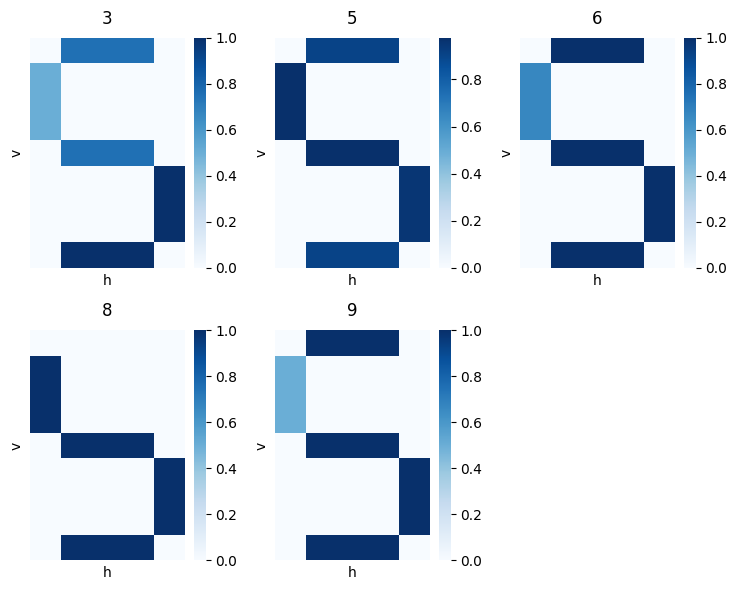

In [545]:
res = df[(df['KMeans'] == 6) & ((df['A'] == 3) | (df['A'] == 5) | (df['A'] == 6) |
                                (df['A'] == 8) | (df['A'] == 9))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                                    'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [546]:
# Детальнее рассмотрим 7й кластер
df[df['KMeans'] == 7].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1
4,36,36,36,36,36,36,36,36,36,36
5,1,1,1,1,1,1,1,1,1,1
8,2,2,2,2,2,2,2,2,2,2
9,4,4,4,4,4,4,4,4,4,4


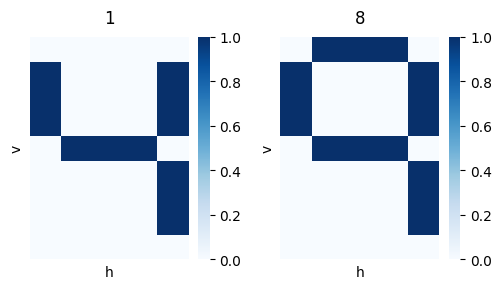

In [547]:
res = df[(df['KMeans'] == 7) & ((df['A'] == 1) | (df['A'] == 7) | (df['A'] == 8))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                             'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [548]:
# Детальнее рассмотрим 8й кластер
df[df['KMeans'] == 8].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
1,37,37,37,37,37,37,37,37,37,37
4,5,5,5,5,5,5,5,5,5,5
7,6,6,6,6,6,6,6,6,6,6
8,1,1,1,1,1,1,1,1,1,1


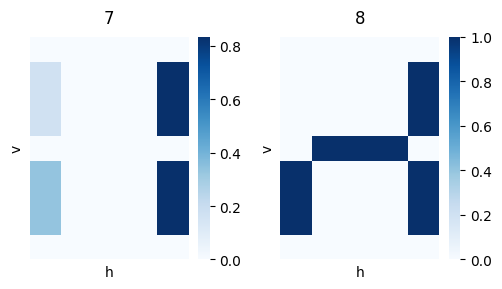

In [549]:
res = df[(df['KMeans'] == 8) & ((df['A'] == 0) | (df['A'] == 2) | (df['A'] == 3) |
                                (df['A'] == 5) | (df['A'] == 6) | (df['A'] == 7) |
                                (df['A'] == 8) | (df['A'] == 9))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                                    'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [550]:
# Детальнее рассмотрим 9й кластер
df[df['KMeans'] == 9].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1
2,4,4,4,4,4,4,4,4,4,4
3,28,28,28,28,28,28,28,28,28,28
4,1,1,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1,1,1
9,7,7,7,7,7,7,7,7,7,7


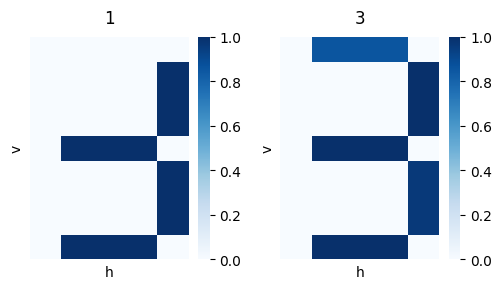

In [551]:
res = df[(df['KMeans'] == 9) & ((df['A'] == 0) | (df['A'] == 1) | (df['A'] == 3))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                                                     'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

### Выводы:
- Все цифры были кластеризованы верно
- В исходном датасете некторые цифры были неверно кластеризованы (столбец А)
- Цифры 2, 3, 5, 6, 7, 8 имеют сильное перекрытие между несколькими кластерами
- "1" в основном попадает в кластер 3 (83%)
- "9" преимущественно в кластере 1 (70%)

# Кластерный анализ методом DBSCAN

In [552]:
# eps - расстояние между соседями
# min_samples - число соседей для корневого объекта
clf = DBSCAN(eps = .9, metric = 'euclidean', min_samples = 12, algorithm = 'auto')
clf.fit(df_clear)

DBSCAN(eps=0.9, min_samples=12)

In [553]:
counts, unique = np.unique(clf.labels_, return_counts = True)
pd.Series(unique, counts)

-1    210
 0     24
 1     18
 2     26
 3     35
 4     24
 5     42
 6     36
 7     29
 8     25
 9     31
dtype: int64

In [554]:
df['DBSCAN'] = clf.labels_
df

,A,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
0,7,1,0,1,0,0,1,0,3,2,0
1,1,0,0,1,0,0,1,0,3,8,1
2,4,0,1,1,1,0,1,0,1,7,2
3,2,1,1,1,1,1,0,0,7,0,-1
4,8,0,1,1,1,1,1,1,2,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
495,5,1,1,0,1,0,1,1,6,6,3
496,7,1,0,1,1,1,1,0,5,3,-1
497,4,0,0,1,1,1,0,0,7,4,-1
498,0,1,1,1,0,0,1,0,3,2,-1


In [555]:
df.groupby('DBSCAN').mean()

,A,B,C,D,E,F,G,H,fcluster,KMeans
DBSCAN,,,,,,,,,,
-1,4.409524,0.614286,0.504762,0.652381,0.666667,0.457143,0.714286,0.533333,5.12381,4.938095
0,6.750000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.00000,2.000000
1,1.666667,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.00000,8.000000
2,3.884615,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.00000,7.000000
3,5.400000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,6.00000,6.000000
4,2.208333,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,7.00000,4.000000
5,7.500000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,9.00000,1.000000
6,7.444444,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.00000,0.000000
7,5.931034,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,6.00000,5.000000


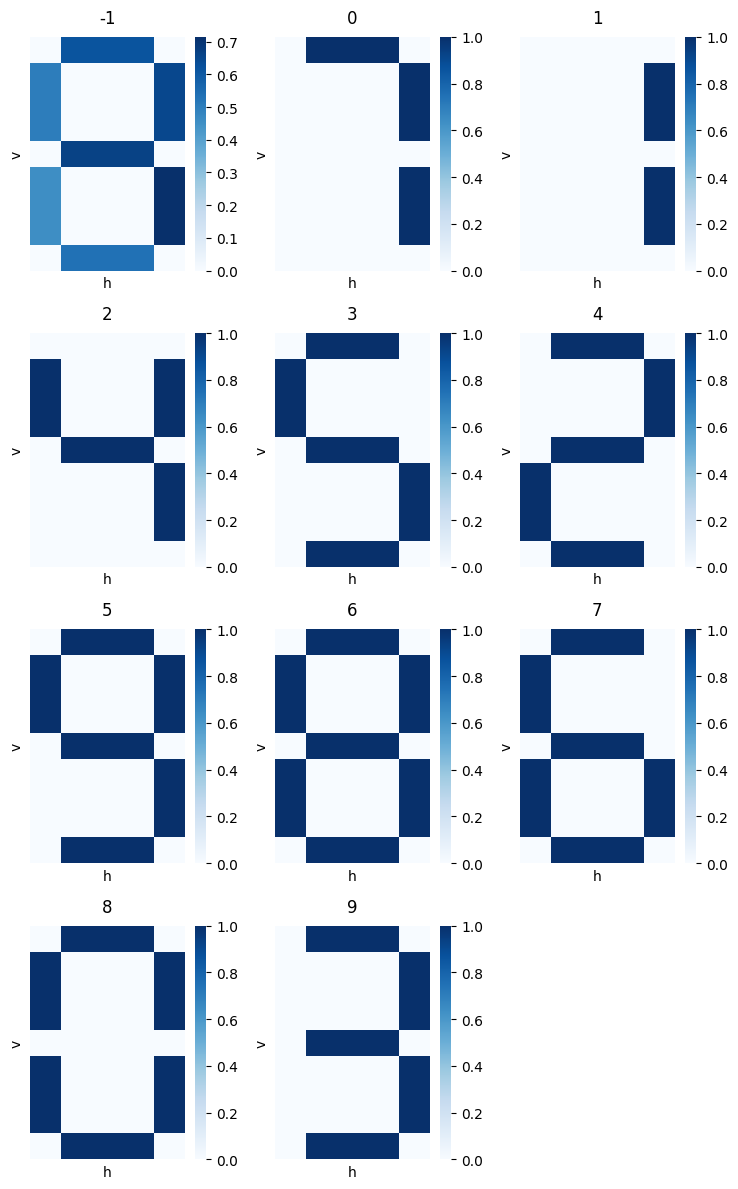

In [556]:
# Визуализируем данные, полученные в результате кластеризации dbscan

digit_visual(df.groupby('DBSCAN').mean())

In [557]:
# Детальнее рассмотрим -1й кластер
df[df['DBSCAN'] == -1].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
0,15,15,15,15,15,15,15,15,15,15
1,25,25,25,25,25,25,25,25,25,25
2,20,20,20,20,20,20,20,20,20,20
3,26,26,26,26,26,26,26,26,26,26
4,27,27,27,27,27,27,27,27,27,27
5,16,16,16,16,16,16,16,16,16,16
6,23,23,23,23,23,23,23,23,23,23
7,23,23,23,23,23,23,23,23,23,23
8,19,19,19,19,19,19,19,19,19,19


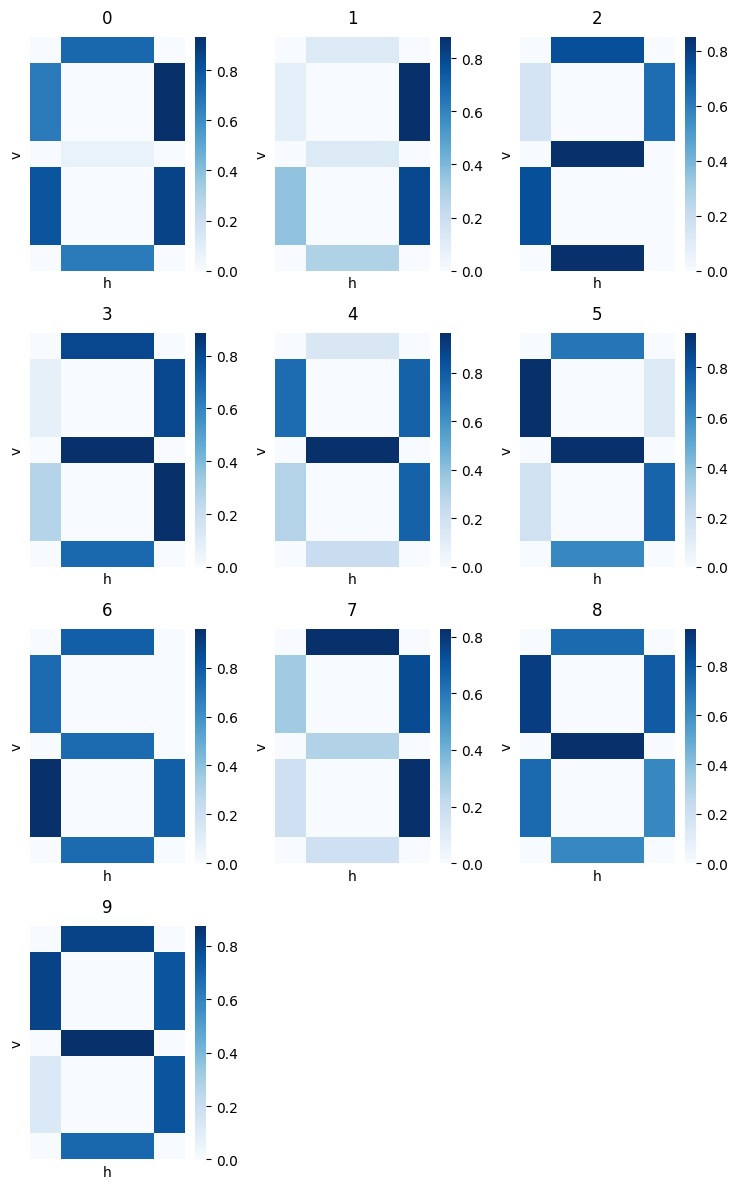

In [558]:
res = df[(df['DBSCAN'] == -1) & ((df['A'] == 0) | (df['A'] == 1) | (df['A'] == 2) |
                                (df['A'] == 3) | (df['A'] == 4) | (df['A'] == 5) |
                                (df['A'] == 6) | (df['A'] == 7) | (df['A'] == 8) |
                                (df['A'] == 9))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                   'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [559]:
res

,B,C,D,E,F,G,H
A,,,,,,,
0,0.733333,0.666667,0.933333,0.066667,0.800000,0.866667,0.666667
1,0.120000,0.080000,0.880000,0.120000,0.360000,0.800000,0.280000
2,0.750000,0.150000,0.650000,0.850000,0.750000,0.000000,0.850000
3,0.807692,0.076923,0.807692,0.884615,0.269231,0.884615,0.692308
4,0.148148,0.740741,0.777778,0.962963,0.296296,0.777778,0.222222
5,0.687500,0.937500,0.125000,0.937500,0.187500,0.750000,0.625000
6,0.782609,0.739130,0.000000,0.739130,0.956522,0.782609,0.739130
7,0.826087,0.304348,0.739130,0.260870,0.173913,0.826087,0.173913
8,0.736842,0.894737,0.789474,0.947368,0.736842,0.631579,0.631579


In [560]:
# Детальнее рассмотрим 0й кластер
df[df['DBSCAN'] == 0].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1
7,23,23,23,23,23,23,23,23,23,23


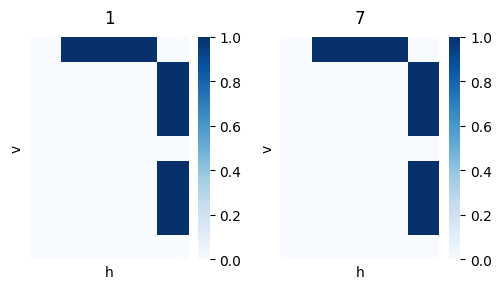

In [561]:
res = df[(df['DBSCAN'] == 0) & ((df['A'] == 1) | (df['A'] == 7))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                                    'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [562]:
# Детальнее рассмотрим 1й кластер
df[df['DBSCAN'] == 1].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
1,16,16,16,16,16,16,16,16,16,16
7,2,2,2,2,2,2,2,2,2,2


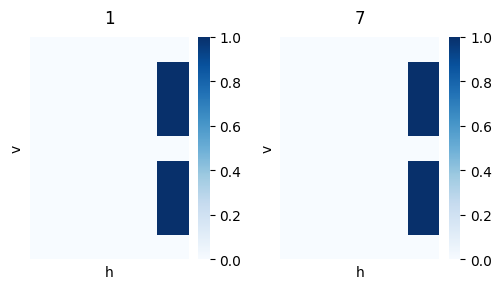

In [563]:
res = df[(df['DBSCAN'] == 1) & ((df['A'] == 1) | (df['A'] == 7))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                                    'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [564]:
# Детальнее рассмотрим 2й кластер
df[df['DBSCAN'] == 2].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1
4,25,25,25,25,25,25,25,25,25,25


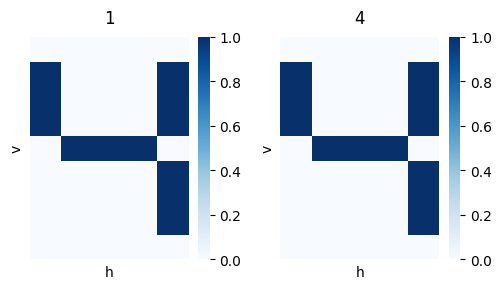

In [565]:
res = df[(df['DBSCAN'] == 2) & ((df['A'] == 1) | (df['A'] == 4))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                                    'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [566]:
# Детальнее рассмотрим 3й кластер
df[df['DBSCAN'] == 3].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
5,30,30,30,30,30,30,30,30,30,30
6,2,2,2,2,2,2,2,2,2,2
9,3,3,3,3,3,3,3,3,3,3


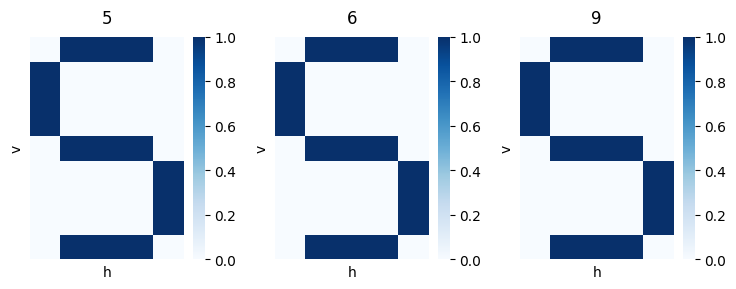

In [567]:
res = df[(df['DBSCAN'] == 3) & ((df['A'] == 5) | (df['A'] == 6) | (df['A'] == 9))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                                                     'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [568]:
# Детальнее рассмотрим 4й кластер
df[df['DBSCAN'] == 4].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1
2,22,22,22,22,22,22,22,22,22,22
9,1,1,1,1,1,1,1,1,1,1


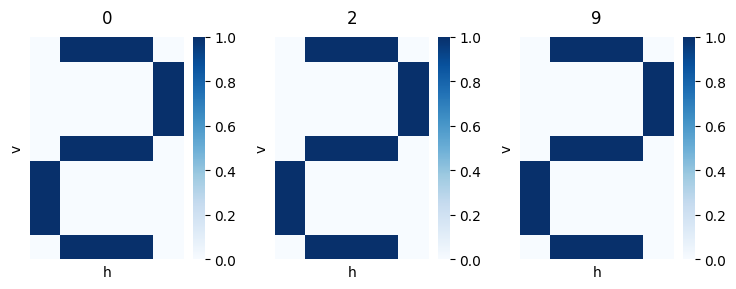

In [569]:
res = df[(df['DBSCAN'] == 4) & ((df['A'] == 0) | (df['A'] == 2) | (df['A'] == 9))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                                                     'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [570]:
# Детальнее рассмотрим 5й кластер
df[df['DBSCAN'] == 5].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1
3,5,5,5,5,5,5,5,5,5,5
5,5,5,5,5,5,5,5,5,5,5
8,4,4,4,4,4,4,4,4,4,4
9,27,27,27,27,27,27,27,27,27,27


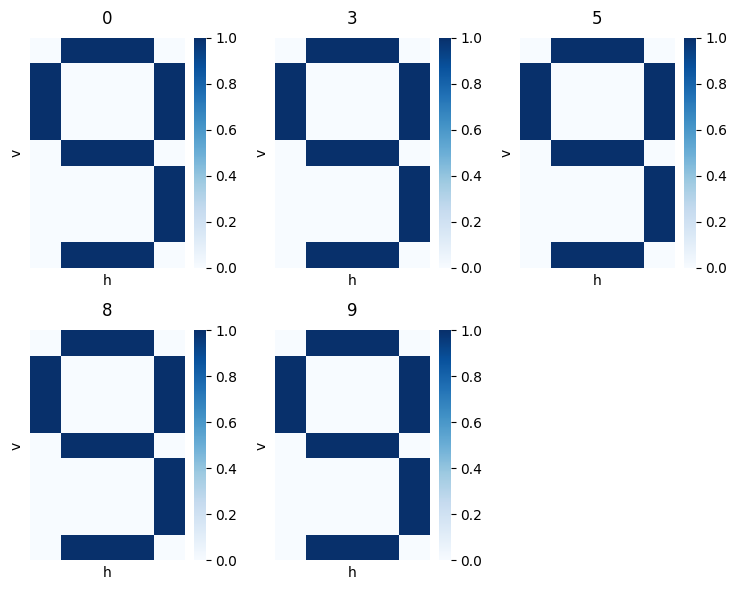

In [571]:
res = df[(df['DBSCAN'] == 5) & ((df['A'] == 0) | (df['A'] == 3) | (df['A'] == 5) |
                                (df['A'] == 8) | (df['A'] == 9))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                                    'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [572]:
# Детальнее рассмотрим 6й кластер
df[df['DBSCAN'] == 6].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
0,2,2,2,2,2,2,2,2,2,2
5,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1
8,31,31,31,31,31,31,31,31,31,31
9,1,1,1,1,1,1,1,1,1,1


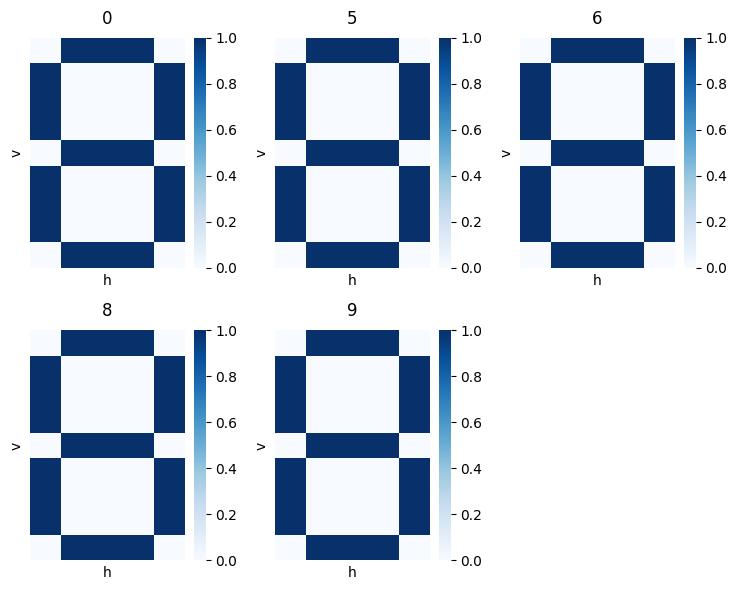

In [573]:
res = df[(df['DBSCAN'] == 6) & ((df['A'] == 0) | (df['A'] == 5) | (df['A'] == 6) |
                                (df['A'] == 8) | (df['A'] == 9))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                                    'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [574]:
# Детальнее рассмотрим 7й кластер
df[df['DBSCAN'] == 7].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
2,1,1,1,1,1,1,1,1,1,1
5,2,2,2,2,2,2,2,2,2,2
6,24,24,24,24,24,24,24,24,24,24
8,2,2,2,2,2,2,2,2,2,2


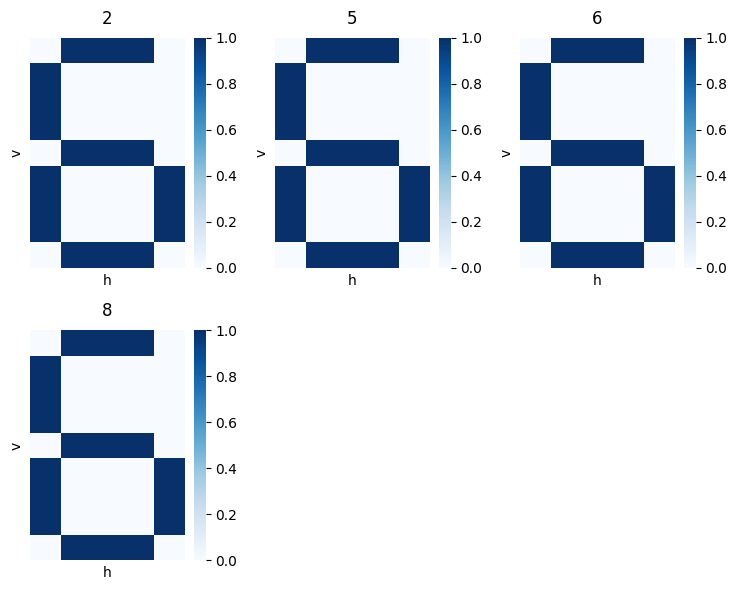

In [575]:
res = df[(df['DBSCAN'] == 7) & ((df['A'] == 2) | (df['A'] == 5) | (df['A'] == 6) |
                                (df['A'] == 8))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                   'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [576]:
# Детальнее рассмотрим 8й кластер
df[df['DBSCAN'] == 8].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
0,23,23,23,23,23,23,23,23,23,23
3,1,1,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1,1,1


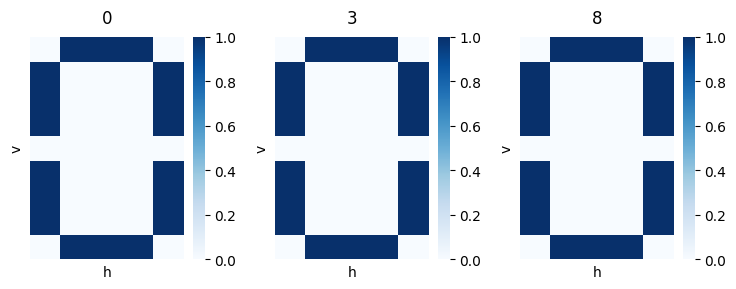

In [577]:
res = df[(df['DBSCAN'] == 8) & ((df['A'] == 0) | (df['A'] == 3) | (df['A'] == 8))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                                                     'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [578]:
# Детальнее рассмотрим 9й кластер
df[df['DBSCAN'] == 9].groupby('A').count()

,B,C,D,E,F,G,H,fcluster,KMeans,DBSCAN
A,,,,,,,,,,
3,23,23,23,23,23,23,23,23,23,23
8,1,1,1,1,1,1,1,1,1,1
9,7,7,7,7,7,7,7,7,7,7


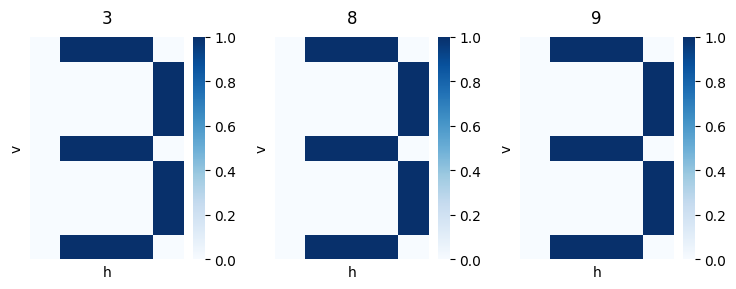

In [579]:
res = df[(df['DBSCAN'] == 9) & ((df['A'] == 3) | (df['A'] == 8) | (df['A'] == 9))].groupby('A').agg({'B': 'mean', 'C': 'mean', 'D': 'mean', 'E': 'mean',
                                                                                                     'F': 'mean', 'G': 'mean', 'H': 'mean'})
res = pd.DataFrame(res)
digit_visual(res)

In [580]:
df.to_csv('1.csv')

### Выводы
- Кластер -1 содержить все шумы - это связано с неполными или аномальными комбинациями линий
- Оставльные кластеры верно классифицировали все цифры

### Общие выводы
- KMeans показывает наиболее структурированные результаты
- DBSCAN лучше всего справляется с выявлением аномалий
- Все методы имеют проблемы с разделением цифр 0, 2, 3, 5, 6
- Наилучшее распознавание у цифр 1, 7, 8 во всех методах